# EC2B1 Coursework -- Portugal and South Africa
*Andres Oats Garcia, Emma Staveley-Wadham, Omar Pozder, Shounak Pal, Tom Baldwin*



In [251]:
#import modules
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns #for nicer plots
from sklearn.linear_model import LinearRegression #to retrieve regression coefficients
from sklearn.metrics import r2_score #to obtain an r squared metric
 

from plotnine import ggplot, aes, geom_line


#set up seaborn
sns.set_theme()
sns.set_palette('Dark2') #Dark2, PuOr, RdBu


In [252]:
#import dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)
data.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [253]:
#cleaning data

#filtering only the relevant columns
df = data.loc[:, ("country", "year", "rgdpe", "pop")]

#calculating real GDP per capita
df["rgdpe_pc"] = df["rgdpe"] / df["pop"]

#filtering our countries
countries = ["Portugal", "South Africa"]
df = df.loc[df["country"].isin(countries), ("country","year", "rgdpe_pc", "rgdpe")]

#resetting the index of the dataset
df = df.reset_index(drop = True)

#calculate logs of rgdpe and rgdpe_pc
df["log_rgdpe"] = df["rgdpe"].apply(np.log)
df["log_rgdpe_pc"] = df["rgdpe_pc"].apply(np.log)



In [254]:
df.head()

,country,year,rgdpe_pc,rgdpe,log_rgdpe,log_rgdpe_pc
0,Portugal,1950,2958.938967,23896.437500,10.081485,7.992586
1,Portugal,1951,3239.131497,26306.451172,10.177569,8.083061
2,Portugal,1952,3338.838936,27230.558594,10.212095,8.113378
3,Portugal,1953,3535.441631,29012.892578,10.275496,8.170594
4,Portugal,1954,3703.070578,30576.775391,10.327996,8.216918


## Section 1: Trend Calculation

We compute the following trend time paths using `scikit-learn` to compute regression coefficients. 

We have used these different specifications for robustness reasons. The additive models use the levels when calculating the trend, whereas the exponential models use the log levels to calculate the trend.



1.   Additive, linear trend (see `get_trend_path_add_lin`), i.e. $$y = \beta_0 + \beta_1 t$$
2.   Additive, quadtratic trend (see `get_trend_path_add_quad`),  i.e. $$y = \beta_0 + \beta_1 t + \beta_2 t^2$$  
3.   Exponential, linear trend (see `get_trend_path_exp_lin`), i.e $$log ~y = \beta_0 + \beta_1 t ~\text{  i.e. }~ y = \text{exp}(\beta_0 + \beta_1 t)$$ 
4.   Exponential, quadratic trend (see `get_trend_path_exp_quad`),  i.e. $$log ~y = \beta_0 + \beta_1 t + \beta_2 t^2  ~\text{  i.e.  }~ y = \text{exp}(\beta_0 + \beta_1 t + \beta_2 t^2)$$ 

where $y$ denotes either `rgdpe` or `rgedpe_pc`. 

For each trend model and country, we plot below log real gdp and log real gdp per capita, with their respective trends.

### Creating functions for each regression type:
We create a function for each regression type that returns the fitted trend values. 

In [255]:
# (1) creating a function that calculates the additive, linear trend path:

def get_trend_path_add_lin(df, column, country):
  '''
    Calculates the additive linear trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time
  x1 = np.arange(1,T+1,1).reshape(-1, 1)  # reshape to create a column vector

  model = LinearRegression() #set the model to be an OLS regression

  #fit the linear regression model
  model.fit(x1,y)

  #set the coefficients to be beta_1 and beta_2
  beta_1 = model.coef_
  beta_0 = model.intercept_

  y_trend = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend[t] = beta_0 + beta_1 * (t + 1)

  #calculate the r squared 
  score = model.score(x1,y)

  return y_trend, score


In [256]:
# (2) creating a function that calculates the additive, quadratic trend path:

def get_trend_path_add_quad(df, column, country):
  '''
    Calculates the additive quadratic trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time and time squared
  x1 = np.arange(1,T+1,1)
  x2 = np.square(x1)

  #combine these arrays into a dataframe
  X = pd.DataFrame({"x1": x1, "x2":x2})

  model = LinearRegression()

  #fit the linear regression model
  model.fit(X,y)

  #set the coefficients to be beta_1 and beta_2
  beta_1, beta_2 = model.coef_
  beta_0 = model.intercept_

  y_trend = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend[t] = beta_0 + beta_1 * (t + 1)  + (beta_2) * ((t+1) **2)
  
  #calculate the r squared
  score = model.score(X,y)

  return y_trend, score

In [257]:
# (3) creating a function that calculates the exponential, linear trend path:

def get_trend_path_exp_lin(df, column, country):
  '''
    Calculates the exponential linear trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time
  x1 = np.arange(1,T+1,1).reshape(-1, 1)  # reshape to create a column vector


  model = LinearRegression()

  #fit the linear regression model
  model.fit(x1,np.log(y)) #take the natural log of y for the exponential fit

  #set the coefficients to be beta_1 and beta_2
  beta_1 = model.coef_
  beta_0 = model.intercept_

  y_trend_log = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend_log[t] = beta_0 + beta_1 * (t + 1)
    
  #calculate the r squared
  score = model.score(x1,np.log(y))

  return np.exp(y_trend_log), score

In [258]:
# (4) creating a function that calculates the exponential, quadratic trend path:

def get_trend_path_exp_quad(df, column, country):
  '''
    Calculates the exponential quadratic trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #array that measures the time and time squared
  x1 = np.arange(1,T+1,1)
  x2 = np.square(x1)

  #combine these arrays into a dataframe
  X = pd.DataFrame({"x1": x1, "x2":x2})

  model = LinearRegression()

  #fit the linear regression model
  model.fit(X,np.log(y)) #take the natural log of y for the exponential fit

  #set the coefficients to be beta_1 and beta_2
  beta_1, beta_2 = model.coef_
  beta_0 = model.intercept_

  y_trend_log = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend_log[t] = beta_0 + beta_1 * (t + 1)  + (beta_2) * ((t+1) **2)
  
  #calculate the r squared
  score = model.score(X,np.log(y))

  return np.exp(y_trend_log), score

### Portugal

#### Creating the plot for log of real GDP in Portugal

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_27780/2585484846.py:11: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

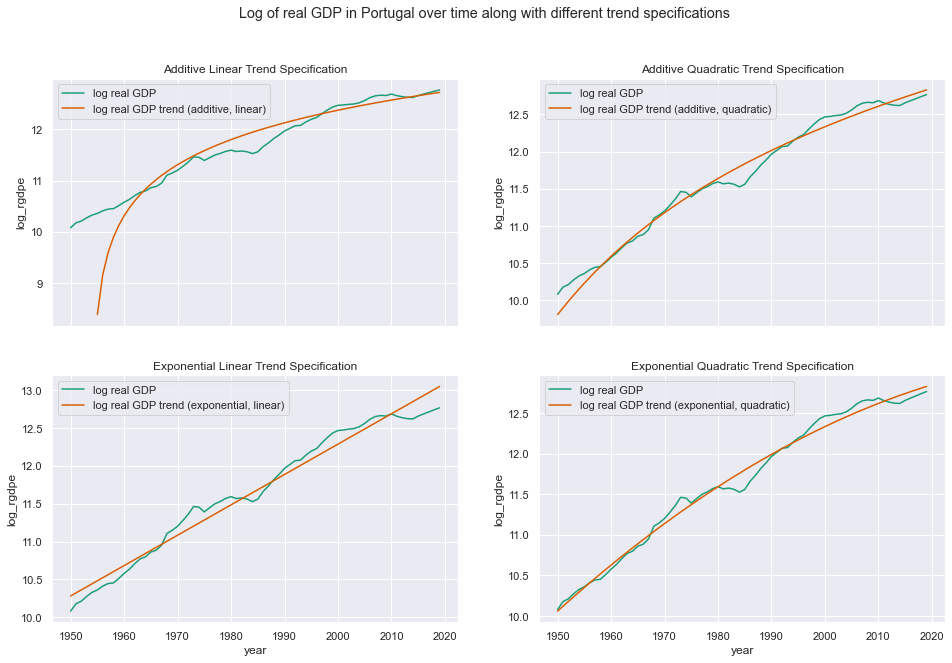

In [259]:
#log real gdp

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP in Portugal over time along with different trend specifications")

df2 = df.loc[df["country"] == "Portugal", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
trend_add_lin, score_add_lin = get_trend_path_add_lin(df2, "rgdpe", "Portugal")
df2["rgdpe_log_trend_add_lin"] = np.log(trend_add_lin) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin", label="log real GDP trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
trend_add_quad, score_add_quad = get_trend_path_add_quad(df2, "rgdpe", "Portugal")
df2["rgdpe_log_trend_add_quad"] = np.log(trend_add_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad", label="log real GDP trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
trend_exp_lin, score_exp_lin = get_trend_path_exp_lin(df2, "rgdpe", "Portugal")
df2["rgdpe_log_trend_exp_lin"] = np.log(trend_exp_lin)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin", label="log real GDP trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
trend_exp_quad, score_exp_quad = get_trend_path_exp_quad(df2, "rgdpe", "Portugal")
df2["rgdpe_log_trend_exp_quad"] = np.log(trend_exp_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

In [260]:
print("R Squared of Each Regression")
print("additive lin.: " + str(score_add_lin))
print("additive quad.: " + str(score_add_quad))
print("exponential lin.: " + str(score_exp_lin))
print("exponential quad.: " + str(score_exp_quad))


R Squared of Each Regression
additive lin.: 0.9461004056894993
additive quad.: 0.975877832078745
exponential lin.: 0.9736748573742438
exponential quad.: 0.9892774200655514


Thus we choose to use the exponential quadratic fit. 

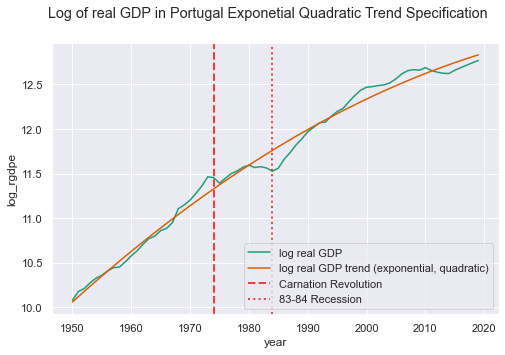

In [261]:
##plot

fig, axes = plt.subplots(1,1, sharex=True, figsize=(8,5))
fig.suptitle("Log of real GDP in Portugal Exponetial Quadratic Trend Specification")

sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes)
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes)

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

#### Creating the plot for log of real GDP per capita in Portugal

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_27780/2047298546.py:11: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

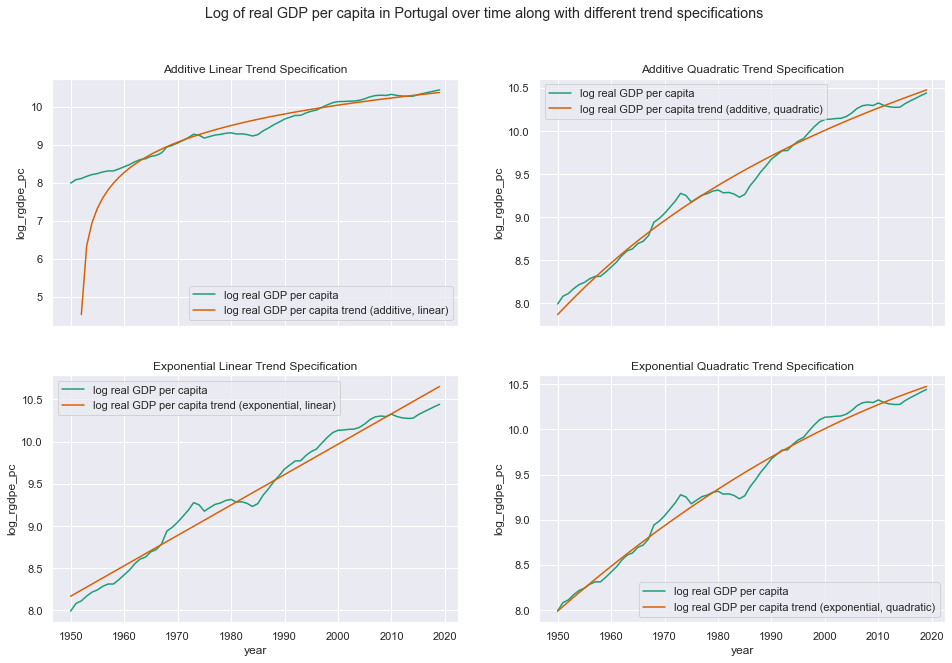

In [262]:
#log real gdp per capita

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP per capita in Portugal over time along with different trend specifications")

df2 = df.loc[df["country"] == "Portugal", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
trend_add_lin, score_add_lin = get_trend_path_add_lin(df2, "rgdpe_pc", "Portugal")
df2["rgdpe_log_trend_add_lin_pc"] = np.log(trend_add_lin) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin_pc", label="log real GDP per capita trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
trend_add_quad, score_add_quad = get_trend_path_add_quad(df2, "rgdpe_pc", "Portugal")
df2["rgdpe_log_trend_add_quad_pc"] = np.log(trend_add_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad_pc", label="log real GDP per capita trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
trend_exp_lin, score_exp_lin = get_trend_path_exp_lin(df2, "rgdpe_pc", "Portugal")
df2["rgdpe_log_trend_exp_lin_pc"] = np.log(trend_exp_lin)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin_pc", label="log real GDP per capita trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
trend_exp_quad, score_exp_quad = get_trend_path_exp_quad(df2, "rgdpe_pc", "Portugal")
df2["rgdpe_log_trend_exp_quad_pc"] = np.log(trend_exp_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

In [263]:
print("R Squared of Each Regression")
print("additive lin.: " + str(score_add_lin))
print("additive quad.: " + str(score_add_quad))
print("exponential lin.: " + str(score_exp_lin))
print("exponential quad.: " + str(score_exp_quad))


R Squared of Each Regression
additive lin.: 0.9502027319066273
additive quad.: 0.9772028307729279
exponential lin.: 0.9721699324447391
exponential quad.: 0.9849627648467791


Thus we choose to use the exponential quadratic fit. 

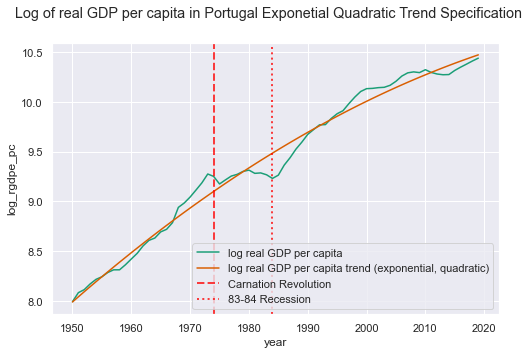

In [264]:
##plot 

fig, axes = plt.subplots(1,1, sharex=True, figsize=(8,5))
fig.suptitle("Log of real GDP per capita in Portugal Exponetial Quadratic Trend Specification")

sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes)
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes)

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

### South Africa

#### Creating the plot for log of real GDP for South Africa

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_27780/4271791757.py:11: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

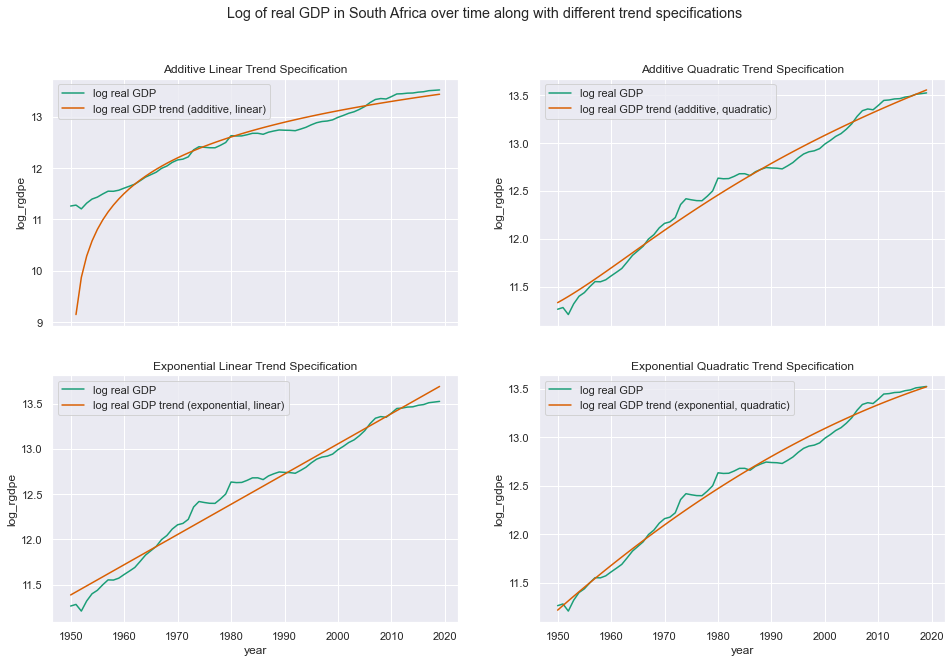

In [265]:
#log real gdp

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP in South Africa over time along with different trend specifications")

df2 = df.loc[df["country"] == "South Africa", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
trend_add_lin, score_add_lin = get_trend_path_add_lin(df2, "rgdpe", "South Africa")
df2["rgdpe_log_trend_add_lin"] = np.log(trend_add_lin) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin", label="log real GDP trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
trend_add_quad, score_add_quad = get_trend_path_add_quad(df2, "rgdpe", "South Africa")
df2["rgdpe_log_trend_add_quad"] = np.log(trend_add_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad", label="log real GDP trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
trend_exp_lin, score_exp_lin = get_trend_path_exp_lin(df2, "rgdpe", "South Africa")
df2["rgdpe_log_trend_exp_lin"] = np.log(trend_exp_lin)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin", label="log real GDP trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
trend_exp_quad, score_exp_quad = get_trend_path_exp_quad(df2, "rgdpe", "South Africa")
df2["rgdpe_log_trend_exp_quad"] = np.log(trend_exp_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

In [266]:
print("R Squared of Each Regression")
print("additive lin.: " + str(score_add_lin))
print("additive quad.: " + str(score_add_quad))
print("exponential lin.: " + str(score_exp_lin))
print("exponential quad.: " + str(score_exp_quad))


R Squared of Each Regression
additive lin.: 0.9489355185353803
additive quad.: 0.9847522315968504
exponential lin.: 0.975056991179773
exponential quad.: 0.9883054879782305


So we use Exponential Quadratic Trend.

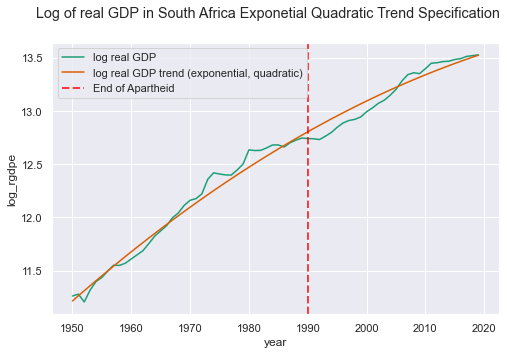

In [267]:
##plot 

fig, axes = plt.subplots(1,1, sharex=True, figsize=(8,5))
fig.suptitle("Log of real GDP in South Africa Exponetial Quadratic Trend Specification")

sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes)
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes)

axes.axvline(x=1990, color='red', linestyle='--', linewidth=2, label="End of Apartheid", alpha=0.75)
axes.legend()

#### Creating the plot for log of real GDP per capita for South Africa

Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

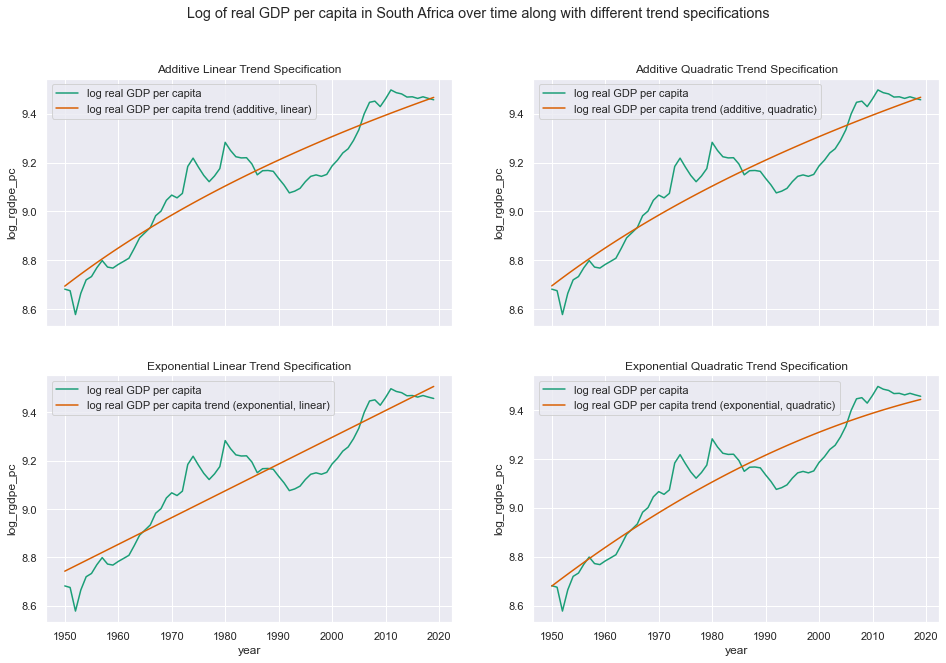

In [268]:
#log real gdp per capita

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP per capita in South Africa over time along with different trend specifications")

df2 = df.loc[df["country"] == "South Africa", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
trend_add_lin, score_add_lin = get_trend_path_add_lin(df2, "rgdpe_pc", "South Africa")
df2["rgdpe_log_trend_add_lin_pc"] = np.log(trend_add_lin) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin_pc", label="log real GDP per capita trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
trend_add_quad, score_add_quad = get_trend_path_add_quad(df2, "rgdpe_pc", "South Africa")
df2["rgdpe_log_trend_add_quad_pc"] = np.log(trend_add_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad_pc", label="log real GDP per capita trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
trend_exp_lin, score_exp_lin = get_trend_path_exp_lin(df2, "rgdpe_pc", "South Africa")
df2["rgdpe_log_trend_exp_lin_pc"] = np.log(trend_exp_lin)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin_pc", label="log real GDP per capita trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
trend_exp_quad, score_exp_quad = get_trend_path_exp_quad(df2, "rgdpe_pc", "South Africa")
df2["rgdpe_log_trend_exp_quad_pc"] = np.log(trend_exp_quad)

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

In [269]:
print("R Squared of Each Regression")
print("additive lin.: " + str(score_add_lin))
print("additive quad.: " + str(score_add_quad))
print("exponential lin.: " + str(score_exp_lin))
print("exponential quad.: " + str(score_exp_quad))


R Squared of Each Regression
additive lin.: 0.8580279950564578
additive quad.: 0.8580298878360879
exponential lin.: 0.8545895285087481
exponential quad.: 0.8692009472240769


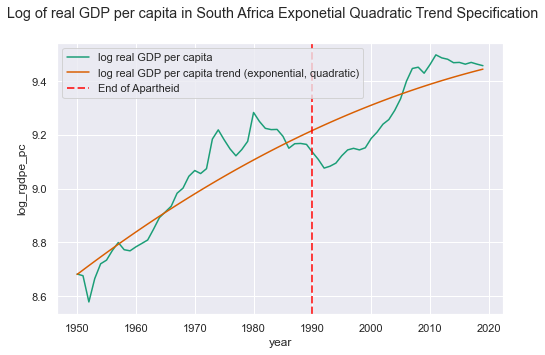

In [270]:
##plot 

fig, axes = plt.subplots(1,1, sharex=True, figsize=(8,5))
fig.suptitle("Log of real GDP per capita in South Africa Exponetial Quadratic Trend Specification")

sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes)
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes)

axes.axvline(x=1990, color='red', linestyle='--', linewidth=2, label="End of Apartheid", alpha=0.75)
axes.legend()

## Section 2: Extracting a Measure for TFP

We consider two production functions when extracting a measure for TFP:

Standard Cobb Douglas:
$$ Y_t=A_t K_t^\alpha L_t^{1-\alpha}$$ 

Human Capital Cobb Douglas:
$$ Y_t=A_t K_t^\alpha L_t^{1-\alpha} H_t^{1-\alpha}$$ 

where $Y_t$ denotes real GDP, $A_t$ denotes TFP, $K_t$ denotes capital, $L_t$ denotes labour and $H_t$ denotes human capital. We set $\alpha = 1/3$, as this follows the general literature *(Hall and Jones (1999), Aiyar and Feyrer (2002))*. However, for robustness, we also use some other values of $\alpha$.

Rearranging gives:

$$A_t = Y_t K_t^{-\alpha} L_t^{\alpha-1} $$ 

and 

$$A_t = Y_t K_t^{-\alpha} L_t^{\alpha-1} H_t^{\alpha-1}$$ 

The standard cobb douglas production function extracts a measure for TFP, whilst the human capital cobb douglas function extracts a measure for TFP controlling for human capital.

For $Y$ we use `rgdpna` (real gdp), for $K$ we use `rnna` (capital stock at 2017 prices), for $L$ we use `emp` (number of employed workers), and for $H$ we use `hc` (human capital index).

In [271]:
#filtering only the relevant columns
tfp_df = data.loc[:, ("country", "year", "rgdpna", "pop", "rnna", "hc", "emp", "ctfp")]

#filtering our countries
countries = ["Portugal", "South Africa"]
tfp_df = tfp_df.loc[tfp_df["country"].isin(countries), ("country", "year", "rgdpna", "pop", "rnna", "hc", "emp","ctfp")]

tfp_df = tfp_df.reset_index(drop = True)

#calculate logs of rgdpe and rgdpe_pc
tfp_df["log_rgdpna"] = tfp_df["rgdpna"].apply(np.log)
tfp_df["log_rnna"] = tfp_df["rnna"].apply(np.log)
tfp_df["log_hc"] = tfp_df["hc"].apply(np.log)
tfp_df["log_emp"] = tfp_df["emp"].apply(np.log)

tfp_df.head()

,country,year,rgdpna,pop,rnna,hc,emp,ctfp,log_rgdpna,log_rnna,log_hc,log_emp
0,Portugal,1950,32679.031250,8.076016,200970.093750,1.241877,3.048248,NaN,10.394489,12.210911,0.216624,1.114567
1,Portugal,1951,35689.503906,8.121452,208849.187500,1.247894,3.046919,NaN,10.482612,12.249368,0.221457,1.114131
2,Portugal,1952,37142.679688,8.155697,218197.375000,1.253940,3.041210,NaN,10.522522,12.293155,0.226290,1.112256
3,Portugal,1953,39096.964844,8.206299,230241.484375,1.260015,3.041408,NaN,10.573800,12.346884,0.231124,1.112320
4,Portugal,1954,40841.328125,8.257141,241873.718750,1.266120,3.041463,0.72594,10.617450,12.396171,0.235957,1.112339


### Standard Cobb Douglas

In [272]:
def StandCobbDouglas(df,alpha):
    tfp = df["rgdpna"] * np.power(df["rnna"],-alpha) * np.power(df["emp"],alpha-1)
    return tfp

def HumanCapitalCobbDouglas(df,alpha):
    tfp = df["rgdpna"] * np.power(df["rnna"],-alpha) * np.power(df["emp"],alpha-1)  * np.power(df["hc"],alpha-1)
    return tfp

###  Human Capital Control Cobb Douglas Regression

### Portugal TFP Measure

In [273]:
#calculating TFP for Portugal
portugal_df = tfp_df.loc[tfp_df["country"] == "Portugal", ("country", "year", "rgdpna", "rnna", "hc", "emp",  "log_rgdpna", "log_rnna", "log_hc", "log_emp", "ctfp","pop")]

#calculating tfp

portugal_tfp_stan = StandCobbDouglas(portugal_df,1/3)
portugal_tfp_hc = HumanCapitalCobbDouglas(portugal_df, 1/3)

portugal_tfp_stan_0_4 = StandCobbDouglas(portugal_df,0.4)
portugal_tfp_hc_0_4 = HumanCapitalCobbDouglas(portugal_df, 0.4)

#saving portugal's tfp measure to the dataframe, to be used later
portugal_df["TFP"] = portugal_tfp_stan
portugal_df["log_tfp_stan"] = np.log(portugal_tfp_stan)

Text(0.5, 0.98, 'Total Factor Productivity Measures in Portugal Across Time')

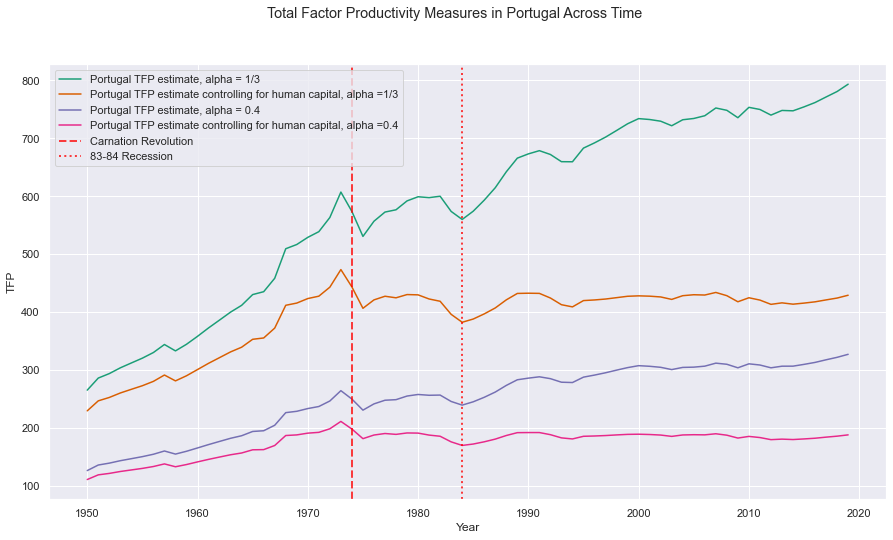

In [274]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=portugal_df["year"], y=portugal_tfp_stan, label="Portugal TFP estimate, alpha = 1/3", ax=axes)
sns.lineplot(x=portugal_df["year"], y=portugal_tfp_hc, label="Portugal TFP estimate controlling for human capital, alpha =1/3", ax=axes)
sns.lineplot(x=portugal_df["year"], y=portugal_tfp_stan_0_4, label="Portugal TFP estimate, alpha = 0.4", ax=axes)
sns.lineplot(x=portugal_df["year"], y=portugal_tfp_hc_0_4, label="Portugal TFP estimate controlling for human capital, alpha =0.4", ax=axes)

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

axes.set_ylabel("TFP")
axes.set_xlabel("Year")
fig.suptitle("Total Factor Productivity Measures in Portugal Across Time")


#### South Africa TFP Measure

In [275]:
#calculating TFP for South Africa
south_africa_df = tfp_df.loc[tfp_df["country"] == "South Africa", ("country", "year", "rgdpna", "rnna", "hc", "emp",  "log_rgdpna", "log_rnna", "log_hc", "log_emp", "ctfp", "pop")]

#the two regressions, on the standard and human capital production functions
south_africa_tfp_stan = StandCobbDouglas(south_africa_df,1/3)
south_africa_tfp_hc = HumanCapitalCobbDouglas(south_africa_df,1/3)
south_africa_tfp_stan_0_4 = StandCobbDouglas(south_africa_df,0.4)
south_africa_tfp_hc_0_4 = HumanCapitalCobbDouglas(south_africa_df,0.4)


#saving the tfp measure to the dataframe to be used later
south_africa_df["TFP"] = south_africa_tfp_stan
south_africa_df["log_tfp_stan"] = np.log(south_africa_tfp_stan)


Text(0.5, 0.98, 'Total Factor Productivity Measures in South Africa Across Time')

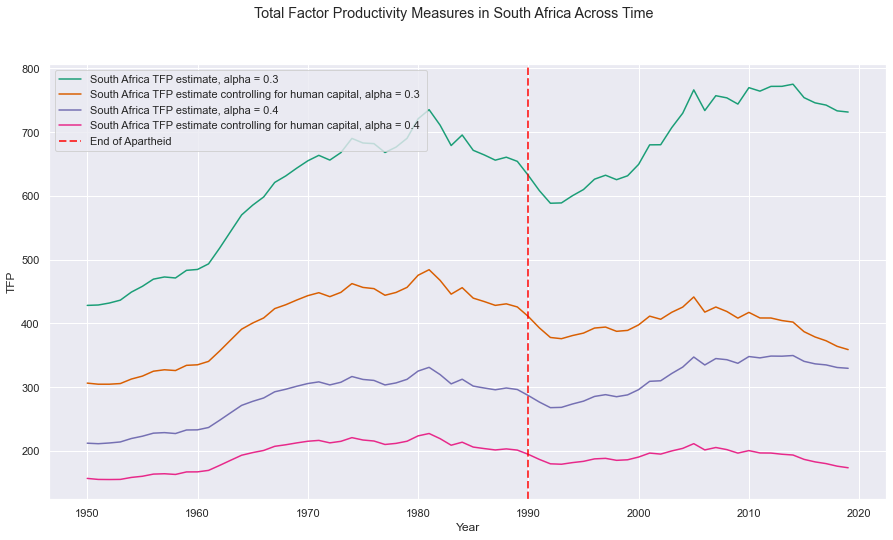

In [276]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_stan, label="South Africa TFP estimate, alpha = 0.3")
sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_hc, label="South Africa TFP estimate controlling for human capital, alpha = 0.3 ")
sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_stan_0_4, label="South Africa TFP estimate, alpha = 0.4")
sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_hc_0_4, label="South Africa TFP estimate controlling for human capital, alpha = 0.4")


axes.axvline(x=1990, color='red', linestyle='--', linewidth=2, label="End of Apartheid", alpha=0.75)
axes.legend()

axes.set_ylabel("TFP")
axes.set_xlabel("Year")
fig.suptitle("Total Factor Productivity Measures in South Africa Across Time")


With higher values of $\alpha$, we see a greater increase in TFP over time. In what follows, we use the benchmark of $\alpha = 1/3$.

## Section 3: Growth Accounting

#### Our Key Equations
$$ Y=A K^\alpha L^{1-\alpha}$$ 

We compute the contribution of technology ($A$) to growth as: $d \log(A) / d \log(Y)$, 

of capital ($K$) as: $\alpha d \log(K) / d\log(Y)$ 

and of labour ($L$) as: $(1- \alpha) d \log(K) / d\log(Y)$


For $A$, we use the measure of TFP we determined above using the standard production function: i.e. `portugal_tfp_stan` and `south_africa_tfp_stan`

We set $\alpha = 1/3$, as this follows the general literature *(Hall and Jones (1999), Aiyar and Feyrer (2002))*. However, for robustness, we also use some other values of $\alpha$.

In [277]:
def GrowthAccount(df, alpha):
    '''
    conducts growth accounting for a given value of alpha
    '''
    df = df.reset_index(drop=True)

    ##calculating the lofs of our variables of interest
    df["log_rnna"] = np.log(df["rnna"])
    df["log_emp"] = np.log(df["emp"])

    #first we calculate the differences of the log columns
    df["log_rdgpna_diff"] = df["log_rgdpna"].diff()
    df["log_rnna_diff"] = df["log_rnna"].diff()
    df["log_tfp_stan_diff"] = df["log_tfp_stan"].diff()
    df["log_emp_diff"] = df["log_emp"].diff()

    #we drop the na values since differencing our data loses an observation. 
    df.dropna()

    #calculating the contriubtions of TFP, K and L using the method described above. 
    contr_TFP = df["log_tfp_stan_diff"]/ df["log_rdgpna_diff"]
    contr_k = alpha * df["log_rnna_diff"] / df["log_rdgpna_diff"]
    contr_l = (1-alpha) * df["log_emp_diff"] / df["log_rdgpna_diff"]

    return contr_k, contr_TFP, contr_l



### Portugal

In [278]:
#calculating contributions for different values of alpha 
portugal_contr_k_0_3, portugal_contr_TFP_0_3, portugal_contr_l_0_3 = GrowthAccount(portugal_df, 1/3)
portugal_contr_k_0_4, portugal_contr_TFP_0_4, portugal_contr_l_0_4 = GrowthAccount(portugal_df, 0.4)
portugal_contr_k_0_5, portugal_contr_TFP_0_5, portugal_contr_l_0_5 = GrowthAccount(portugal_df, 0.5)


Text(0.5, 0.98, 'Contribution of Capital to growth over time in Portugal')

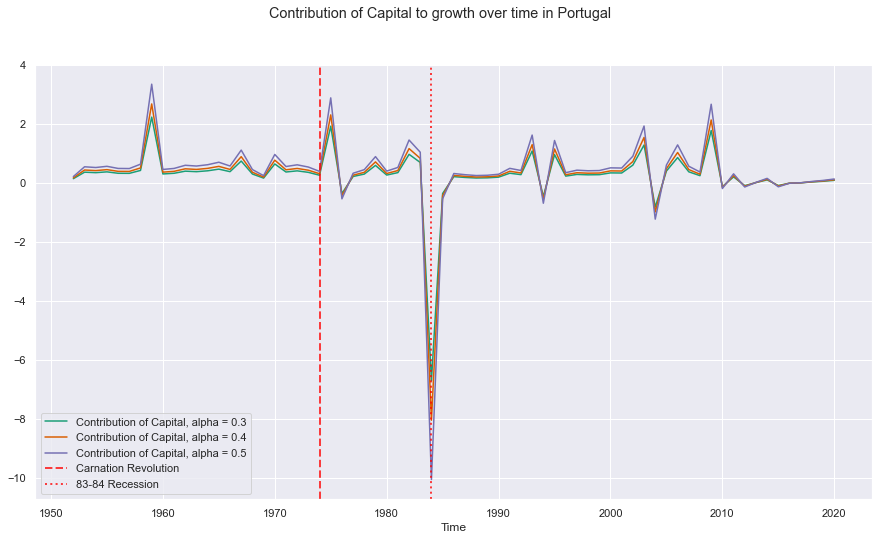

In [279]:
#plotting the contribution of capital for different values of alpha
time = np.arange(1951, 1951+ len(portugal_contr_k_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=portugal_contr_k_0_3, label="Contribution of Capital, alpha = 0.3")
sns.lineplot(x=time, y=portugal_contr_k_0_4, label="Contribution of Capital, alpha = 0.4")
sns.lineplot(x=time, y=portugal_contr_k_0_5, label="Contribution of Capital, alpha = 0.5")

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

axes.set_xlabel("Time")
fig.suptitle("Contribution of Capital to growth over time in Portugal")


Text(0.5, 0.98, 'Contribution of TFP to growth over time in Portugal')

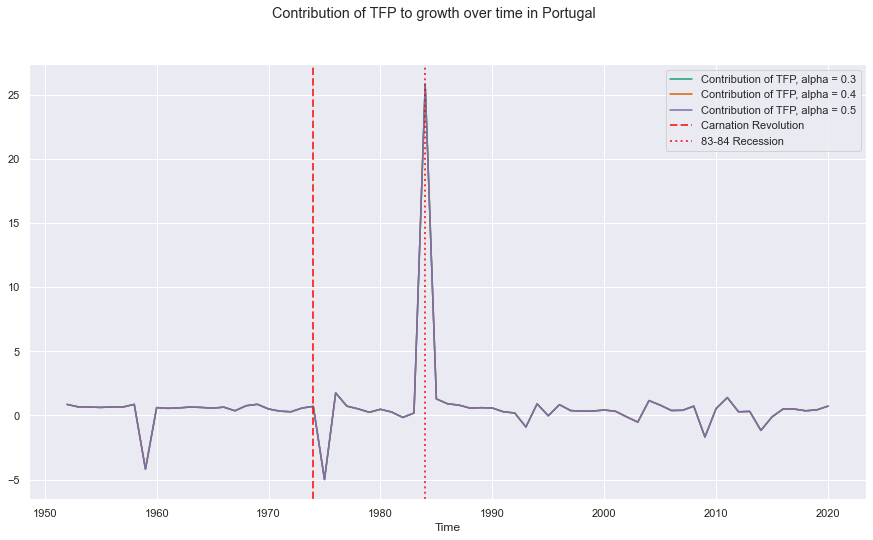

In [280]:
#plotting the contribution of TFP for different values of alpha

time = np.arange(1951, 1951+ len(portugal_contr_k_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=portugal_contr_TFP_0_3, label="Contribution of TFP, alpha = 0.3")
sns.lineplot(x=time, y=portugal_contr_TFP_0_4, label="Contribution of TFP, alpha = 0.4")
sns.lineplot(x=time, y=portugal_contr_TFP_0_5, label="Contribution of TFP, alpha = 0.5")

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

axes.set_xlabel("Time")
fig.suptitle("Contribution of TFP to growth over time in Portugal")


Text(0.5, 0.98, 'Contribution of Labour to growth over time in Portugal')

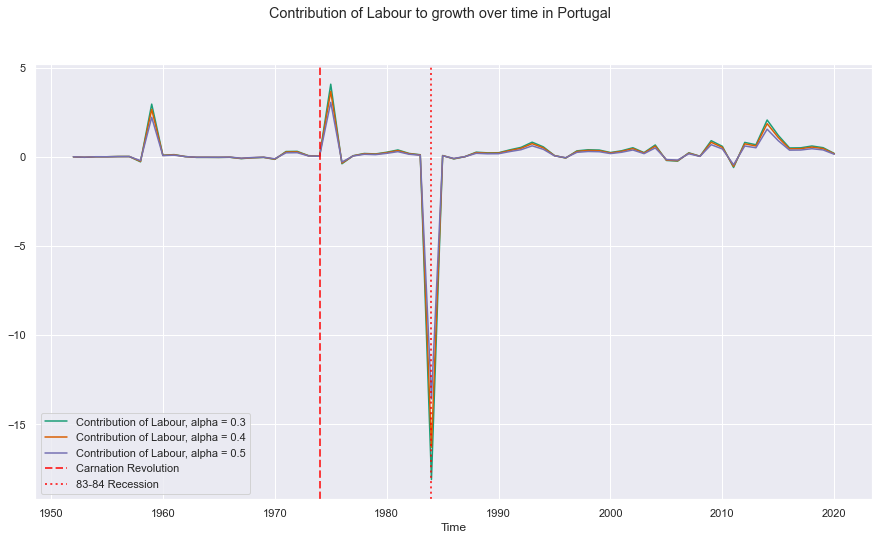

In [281]:
#plotting the contribution of labour for different values of alpha

time = np.arange(1951, 1951+ len(portugal_contr_l_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=portugal_contr_l_0_3, label="Contribution of Labour, alpha = 0.3")
sns.lineplot(x=time, y=portugal_contr_l_0_4, label="Contribution of Labour, alpha = 0.4")
sns.lineplot(x=time, y=portugal_contr_l_0_5, label="Contribution of Labour, alpha = 0.5")

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

axes.set_xlabel("Time")
fig.suptitle("Contribution of Labour to growth over time in Portugal")


Due to the magnitude of outliers, we choose to winsorise the data to limit the magnitude of the outliers that can be seen in the above plots. 

Furthermore, we see that contributions are relatively robust to different choices of alpha. Thus we use $\alpha =0.3$ in what follows, as this is commonly used in the literature.


Text(0.5, 0.98, 'Contribution of Capital, Labour and TFP to growth over time in Portugal, alpha = 0.3')

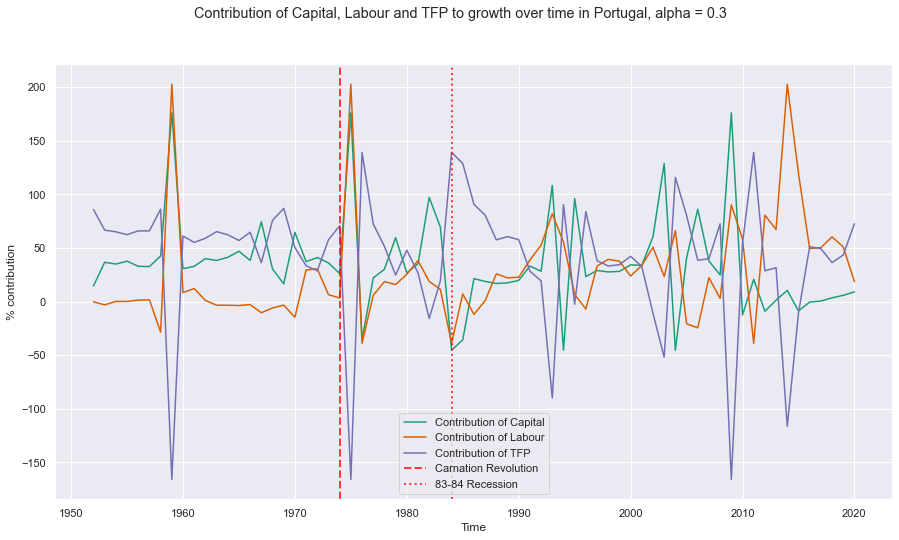

In [282]:
#calculating the upper and lower bounds
lower_bound_k, upper_bound_k = portugal_contr_k_0_3.quantile([0.03, 0.97])
lower_bound_l, upper_bound_l = portugal_contr_l_0_3.quantile([0.03, 0.97])
lower_bound_TFP, upper_bound_TFP = portugal_contr_TFP_0_3.quantile([0.03, 0.97])

#capping the data and converting to percentages
capped_data_contr_k =portugal_contr_k_0_3.clip(lower=lower_bound_k, upper=upper_bound_k) * 100
capped_data_contr_l =portugal_contr_l_0_3.clip(lower=lower_bound_l, upper=upper_bound_l) * 100
capped_data_contr_TFP =portugal_contr_TFP_0_3.clip(lower=lower_bound_TFP, upper=upper_bound_TFP) * 100

time = np.arange(1951, 1951+ len(capped_data_contr_k))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=capped_data_contr_k, label="Contribution of Capital")
sns.lineplot(x=time, y=capped_data_contr_l, label="Contribution of Labour")
sns.lineplot(x=time, y=capped_data_contr_TFP, label="Contribution of TFP")

axes.axvline(x=1974, color='red', linestyle='--', linewidth=2, label="Carnation Revolution", alpha=0.75)
axes.axvline(x=1984, color='red', linestyle=':', linewidth=2, label="83-84 Recession", alpha=0.75)
axes.legend()

axes.set_xlabel("Time")
axes.set_ylabel("% contribution")
fig.suptitle("Contribution of Capital, Labour and TFP to growth over time in Portugal, alpha = 0.3")

We calculate the change in the contribution of each factor over each 10 year period. 

In [283]:
## calculate the end - start for every 10 year period
def calculate_change_over_periods(data, period_length):
    changes = []
    for i in range(1, len(data) - period_length + 1, period_length):
        period_change = data[i + period_length - 1] - data[i]  # Subtract start of period from end
        changes.append(period_change)
    return changes

In [284]:

# Calculate changes over ten-year periods for portugal
changes_k = calculate_change_over_periods(capped_data_contr_k, 10)
changes_l = calculate_change_over_periods(capped_data_contr_l, 10)
changes_TFP = calculate_change_over_periods(capped_data_contr_TFP, 10)

# Print changes for each ten-year period
for i in range(len(changes_k)):
    print(f"Period {i+1} ({1950+i*10}-{1950+(i+1)*10}):")
    print(f"Change in Contribution of Capital: {changes_k[i]}")
    print(f"Change in Contribution of Labour: {changes_l[i]}")
    print(f"Change in Contribution of TFP: {changes_TFP[i]}\n")

Period 1 (1950-1960):
Change in Contribution of Capital: 18.292055992217033
Change in Contribution of Labour: 12.393422803149036
Change in Contribution of TFP: -30.685478795367025

Period 2 (1960-1970):
Change in Contribution of Capital: -2.8033206036500644
Change in Contribution of Labour: 28.375096037652465
Change in Contribution of TFP: -25.571775434002866

Period 3 (1970-1980):
Change in Contribution of Capital: -5.920406922194594
Change in Contribution of Labour: 7.749181414250717
Change in Contribution of TFP: -1.8287744920551958

Period 4 (1980-1990):
Change in Contribution of Capital: -64.0305026257132
Change in Contribution of Labour: 19.988522732121282
Change in Contribution of TFP: 44.04197989358447

Period 5 (1990-2000):
Change in Contribution of Capital: 5.53407283449911
Change in Contribution of Labour: -18.889298254312443
Change in Contribution of TFP: 13.355225419812484

Period 6 (2000-2010):
Change in Contribution of Capital: -39.79388851225494
Change in Contribution o

### South Africa

In [285]:
south_africa_contr_k_0_3, south_africa_contr_TFP_0_3, south_africa_contr_l_0_3 = GrowthAccount(south_africa_df, 1/3)
south_africa_contr_k_0_4, south_africa_contr_TFP_0_4, south_africa_contr_l_0_4 = GrowthAccount(south_africa_df, 0.4)
south_africa_contr_k_0_5, south_africa_contr_TFP_0_5, south_africa_contr_l_0_5 = GrowthAccount(south_africa_df, 0.5)

Text(0.5, 0.98, 'Contribution of Capital to growth over time in South Africa')

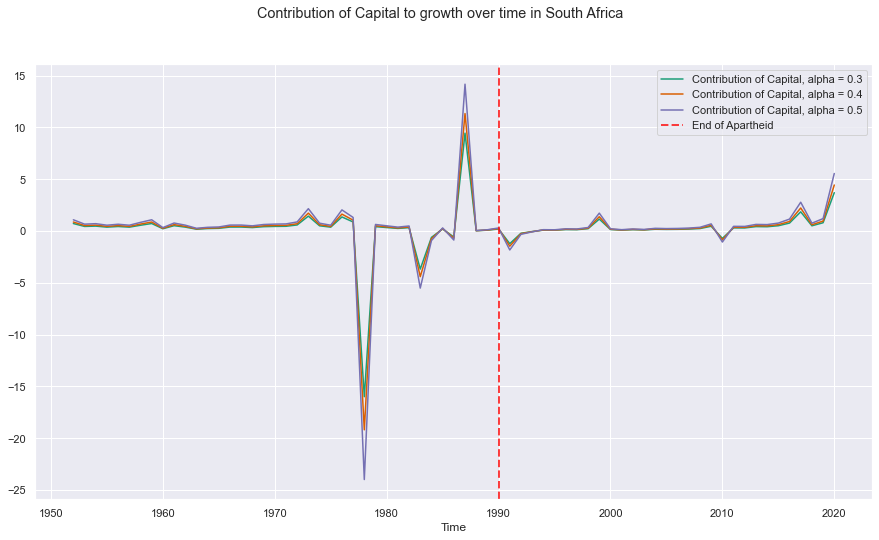

In [286]:
time = np.arange(1951, 1951+ len(south_africa_contr_k_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=south_africa_contr_k_0_3, label="Contribution of Capital, alpha = 0.3")
sns.lineplot(x=time, y=south_africa_contr_k_0_4, label="Contribution of Capital, alpha = 0.4")
sns.lineplot(x=time, y=south_africa_contr_k_0_5, label="Contribution of Capital, alpha = 0.5")

axes.axvline(x=1990, color='red', linestyle='--', linewidth=2, label="End of Apartheid", alpha=0.75)

axes.legend()

axes.set_xlabel("Time")
fig.suptitle("Contribution of Capital to growth over time in South Africa")



Text(0.5, 0.98, 'Contribution of TFP to growth over time in South Africa')

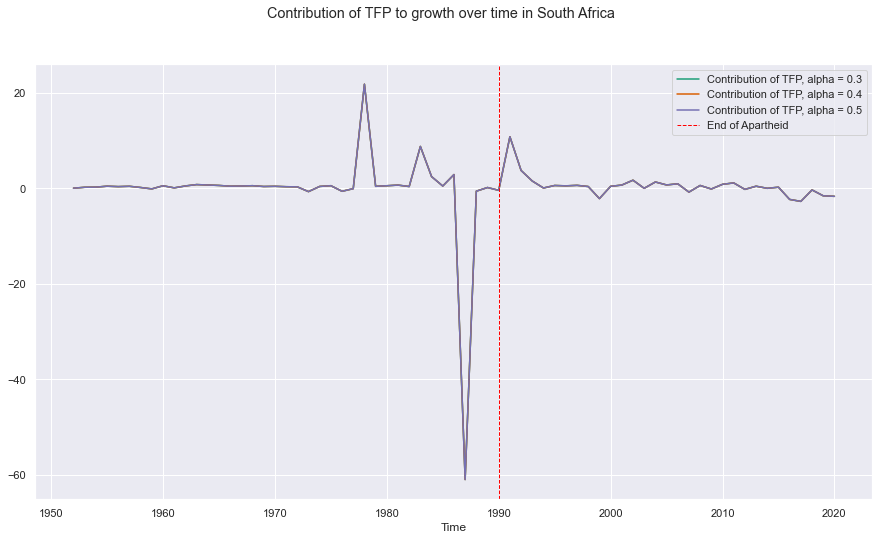

In [287]:
time = np.arange(1951, 1951+ len(south_africa_contr_k_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=south_africa_contr_TFP_0_3, label="Contribution of TFP, alpha = 0.3")
sns.lineplot(x=time, y=south_africa_contr_TFP_0_4, label="Contribution of TFP, alpha = 0.4")
sns.lineplot(x=time, y=south_africa_contr_TFP_0_5, label="Contribution of TFP, alpha = 0.5")

axes.axvline(x=1990, color='red', linestyle='--', linewidth=1, label="End of Apartheid")
axes.legend()

axes.set_xlabel("Time")
fig.suptitle("Contribution of TFP to growth over time in South Africa")


Text(0.5, 0.98, 'Contribution of Labour to growth over time in South Africa')

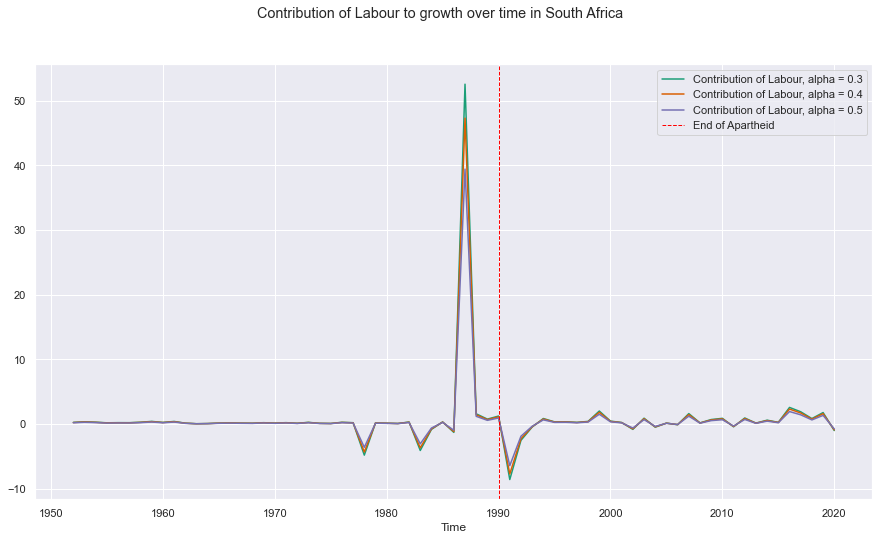

In [288]:
time = np.arange(1951, 1951+ len(south_africa_contr_k_0_3))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=south_africa_contr_l_0_3, label="Contribution of Labour, alpha = 0.3")
sns.lineplot(x=time, y=south_africa_contr_l_0_4, label="Contribution of Labour, alpha = 0.4")
sns.lineplot(x=time, y=south_africa_contr_l_0_5, label="Contribution of Labour, alpha = 0.5")

axes.axvline(x=1990, color='red', linestyle='--', linewidth=1, label="End of Apartheid")
axes.legend()


axes.set_xlabel("Time")
fig.suptitle("Contribution of Labour to growth over time in South Africa")


Due to the magnitude of outliers, we choose to winsorise the data to limit the magnitude of the outliers that can be seen in the above plots. 

Furthermore, we see that contributions are relatively robust to different choices of alpha. Thus we use $\alpha =0.3$ in what follows, as this is commonly used in the literature.


Text(0.5, 0.98, 'Contribution of Capital, Labour and TFP to growth over time in South Africa, alpha = 0.3')

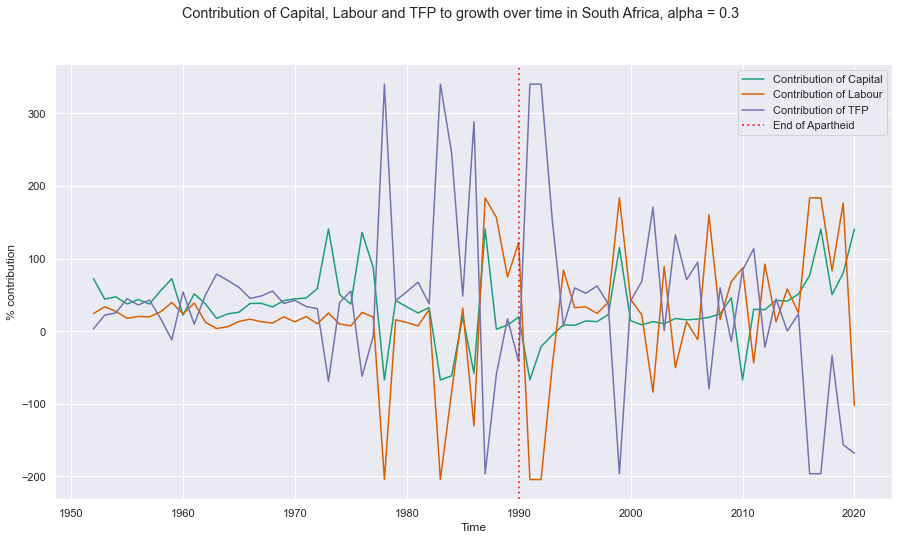

In [289]:
#calculating the upper and lower bounds
lower_bound_k, upper_bound_k = south_africa_contr_k_0_3.quantile([0.05, 0.95])
lower_bound_l, upper_bound_l = south_africa_contr_l_0_3.quantile([0.05, 0.95])
lower_bound_TFP, upper_bound_TFP = south_africa_contr_TFP_0_3.quantile([0.05, 0.95])

#capping the data and converting to percentages
capped_data_contr_k_SA =south_africa_contr_k_0_3.clip(lower=lower_bound_k, upper=upper_bound_k) * 100
capped_data_contr_l_SA =south_africa_contr_l_0_3.clip(lower=lower_bound_l, upper=upper_bound_l) * 100
capped_data_contr_TFP_SA =south_africa_contr_TFP_0_3.clip(lower=lower_bound_TFP, upper=upper_bound_TFP) * 100

time = np.arange(1951, 1951+ len(capped_data_contr_k))

fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=time, y=capped_data_contr_k_SA, label="Contribution of Capital")
sns.lineplot(x=time, y=capped_data_contr_l_SA, label="Contribution of Labour")
sns.lineplot(x=time, y=capped_data_contr_TFP_SA, label="Contribution of TFP")

axes.axvline(x=1990, color='red', linestyle=':', linewidth=2, label="End of Apartheid", alpha=0.75)
axes.legend()

axes.set_xlabel("Time")
axes.set_ylabel("% contribution")
fig.suptitle("Contribution of Capital, Labour and TFP to growth over time in South Africa, alpha = 0.3")

We see that contributions are relatively robust to different choices of alpha, and that our choice of $\alpha =0.3$ is less volatile. Thus we use $\alpha =0.3$ in what follows.

We look at the change in contribution of each factor over 10 year periods. 

In [290]:

# Calculate changes over ten-year periods for south africa
changes_k = calculate_change_over_periods(capped_data_contr_k_SA, 10)
changes_l = calculate_change_over_periods(capped_data_contr_l_SA, 10)
changes_TFP = calculate_change_over_periods(capped_data_contr_TFP_SA, 10)

# Print changes for each ten-year period
for i in range(len(changes_k)):
    print(f"Period {i+1} ({1950+i*10}-{1950+(i+1)*10}):")
    print(f"Change in Contribution of Capital: {changes_k[i]}")
    print(f"Change in Contribution of Labour: {changes_l[i]}")
    print(f"Change in Contribution of TFP: {changes_TFP[i]}\n")


Period 1 (1950-1960):
Change in Contribution of Capital: -20.875230926722224
Change in Contribution of Labour: 14.475895303244709
Change in Contribution of TFP: 6.399335623477684

Period 2 (1960-1970):
Change in Contribution of Capital: 7.939217598986254
Change in Contribution of Labour: 7.827203934421217
Change in Contribution of TFP: -15.766421533405975

Period 3 (1970-1980):
Change in Contribution of Capital: -33.449218103765
Change in Contribution of Labour: -2.9912825172951294
Change in Contribution of TFP: 36.440500621057275

Period 4 (1980-1990):
Change in Contribution of Capital: -99.52628114345677
Change in Contribution of Labour: -234.08129219388584
Change in Contribution of TFP: 302.43588639941754

Period 5 (1990-2000):
Change in Contribution of Capital: 30.016836687885906
Change in Contribution of Labour: 226.74367682816805
Change in Contribution of TFP: -271.4055132831829

Period 6 (2000-2010):
Change in Contribution of Capital: 16.939706535020296
Change in Contribution of

## Section 4: Labour Productivity


In this section, we construct a series for labour productivity in our two countries, i.e. GDP per worker. 

We construct this series as follows: 

$$\text{labour productivity} = \frac Y L$$ 

where $Y$ represents real GDP, for which we use `rgdpna`, and $L$ represents the labour force, for which we use `emp`.

In [291]:
#constructing our series:

portugal_df["labour_product"] = portugal_df["rgdpna"] / portugal_df["emp"]
south_africa_df["labour_product"] = south_africa_df["rgdpna"] / south_africa_df["emp"]

Text(0.5, 0.98, 'Labour & Total Factor Productivity Over Time')

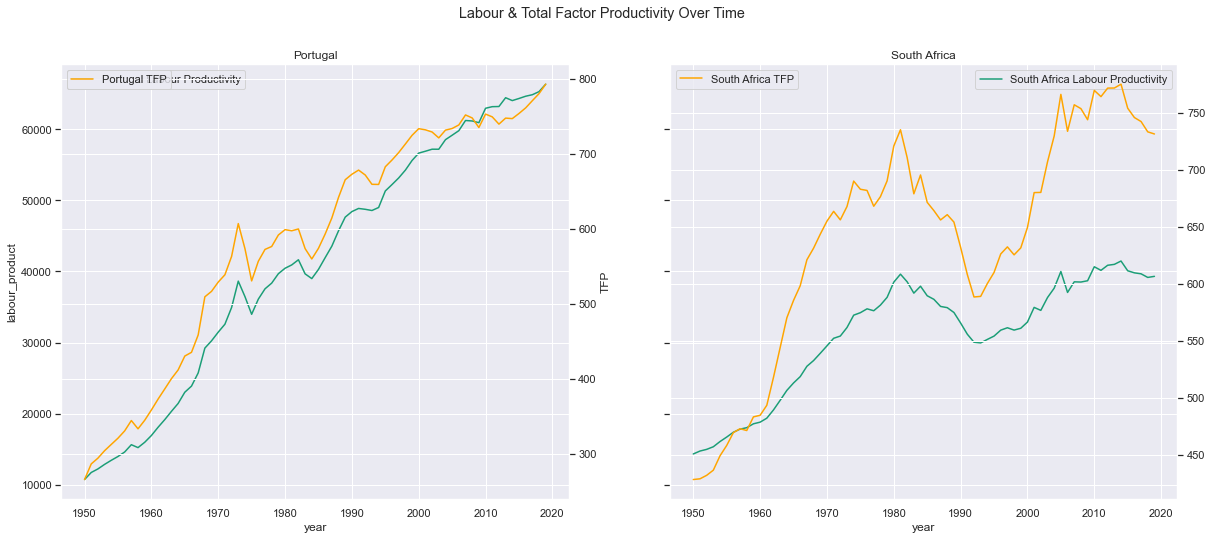

In [292]:
#plotting labour productivity in our countries
fig, axes = plt.subplots(1,2, sharey=True, figsize=(20,8))

axes2 = axes

sns.lineplot(x=portugal_df["year"], y=portugal_df["labour_product"], label="Portugal Labour Productivity", ax=axes[0])

axes2[0] = axes[0].twinx()

sns.lineplot(x=portugal_df["year"], y=portugal_df["TFP"], label="Portugal TFP", ax=axes2[0], color='orange')


sns.lineplot(x=south_africa_df["year"], y=south_africa_df["labour_product"], label="South Africa Labour Productivity",ax=axes[1])

axes2[1] = axes[1].twinx()

sns.lineplot(x=south_africa_df["year"], y=south_africa_df["TFP"], label="South Africa TFP",ax=axes2[1], color='orange')


axes[0].set_title("Portugal")
axes[1].set_title("South Africa")

axes[0].set_ylabel("Labour Productivity")
axes2[0].set_ylabel("TFP")
axes[1].set_ylabel("")


fig.suptitle("Labour & Total Factor Productivity Over Time")
